In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Load measurment into a DF
Mstmt = session.query(Measurement).statement 
MeasurementDF = pd.read_sql_query(Mstmt, session.bind) 

#load Station into a DF
Sstmt = session.query(Station).statement 
StationDF = pd.read_sql_query(Sstmt, session.bind) 

#Look at the latest date form measurement table
LatestDate=pd.Timestamp(MeasurementDF["date"].max())

#calculate 12 months prior to the lates date
Query12Months=LatestDate - pd.DateOffset(months=12)
Query12Months=Query12Months.date()

MeasurementDF.columns

Index(['id', 'station', 'date', 'prcp', 'tobs'], dtype='object')

In [11]:
#load the latest 12 months of data into a DF
TwelveMonthsOfData = session.query(Measurement).filter(func.strftime( Measurement.date) >=Query12Months).statement
TwelveMonthsOfDataDF = pd.read_sql_query(TwelveMonthsOfData, session.bind)

#set index to date and sort by date
TwelveMonthsOfData=TwelveMonthsOfDataDF[["date","prcp"]].set_index("date").sort_values("date")
TwelveMonthsOfData.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [12]:
# Cutom analysis: Find max precipitation
maxprcip= TwelveMonthsOfData.sort_values("prcp",ascending=False).head(1)
annotate=maxprcip.index[0]
annotate

'2016-09-14'

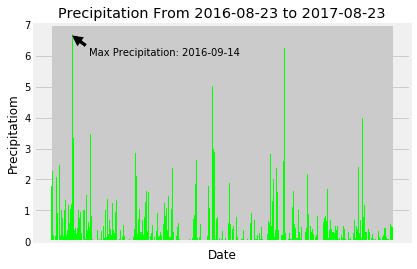

In [13]:
#Plot

fig,    ax = plt.subplots() 
#bar
# Turn off tick labels
ax.set_xticklabels([])

ax.bar(TwelveMonthsOfData.index, TwelveMonthsOfData["prcp"],1, color='lime')

# annotate.
ax.annotate('Max Precipitation: '+ str(annotate), xy=(20, 6.7), xytext=(40, 6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

################## format
#  axis labels
plt.xlabel("Date")
plt.ylabel("Precipitatiom")

#add a title
plt.title("Precipitation From " + str(Query12Months) +" to " +  str(LatestDate.date()))

#disply plot
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
TwelveMonthsOfData["prcp"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [15]:
StationDF["id"].count()

9

In [16]:
StationCountDf=pd.merge(StationDF, MeasurementDF, on="station")

GroupByDF = StationCountDf.groupby(['station'])
StationCount=GroupByDF.count()
StationCount.reset_index(inplace=True)

StationActivity=StationCount[["station","id_x"]].sort_values("id_x", ascending=False)
StationActivity

,station,id_x
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [17]:
#set a variable to store mosr active station
MostActive=StationActivity.head(1)
MostActive.reset_index(inplace=True)
MostActive=MostActive["station"][0]
MostActive

'USC00519281'

In [18]:
#query the most active station
MostActiveDF = MeasurementDF.loc[MeasurementDF["station"]==MostActive]

#return min tob, max temp,avg tob
ActiveStationData=[MostActiveDF["tobs"].min(),MostActiveDF["tobs"].max(),MostActiveDF["tobs"].mean()]
ActiveStationData

[54.0, 85.0, 71.66378066378067]

In [19]:
# Choose the station with the highest number of temperature observations.
StationCount=GroupByDF.count()
StationCount.reset_index(inplace=True)

Stationtemp=StationCount[["station","tobs"]].sort_values("tobs", ascending=False)
Stationtemp

#set a variable to store higest temp station
High=Stationtemp.head(1)
High.reset_index(inplace=True)
HighObsStation=High["station"][0]

HighObsStation


'USC00519281'

In [23]:
HistogramDF=TwelveMonthsOfDataDF.loc[TwelveMonthsOfDataDF["station"]==HighObsStation]

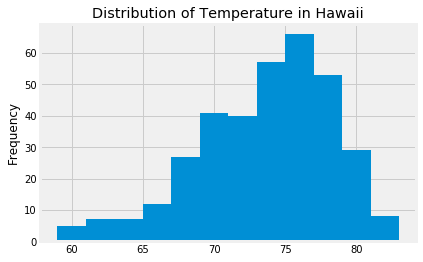

In [24]:
#Plot histogram of temperature
HistogramDF[["tobs"]].plot(kind = "hist",bins=12, legend = False)
plt.title("Distribution of Temperature in Hawaii")
#disply plot
plt.show()

# Climate app

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-12-05', '2016-12-10'))

[(67.0, 70.38461538461539, 76.0)]


# Trip

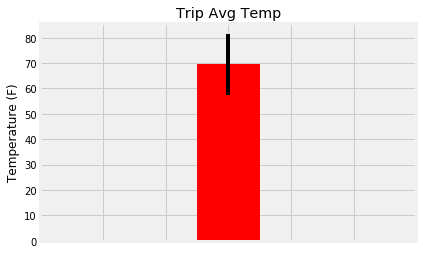

In [27]:
# set the results of the function in variables
TempsList=calc_temps('2012-02-28', '2012-03-05')
Min=TempsList[0][0]
Mean=TempsList[0][1]
Max=TempsList[0][2]
Yerr= TempsList[0][2]-TempsList[0][0]
#Plot


fig,    ax = plt.subplots()
ax.bar(0, Mean,1, yerr= Yerr,color='red')
################## format
#  axis labels

plt.ylabel("Temperature (F)")
plt.xlim(-3, 3)
#add a title
plt.title("Trip Avg Temp")
ax.set_xticklabels([])
#disply plot
plt.show()

